# 动手深度学习 ch3

## 3. 线性神经网络

## 3.1 线性回归

### 线性回归从零开始
---
> - 数据流水线
> - 模型
> - 损失函数
> - 小批量随机梯度下降优化器

In [57]:
"""导入必要的库"""
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
import time
import pandas as pd

### 1.1 生成数据集
---
- 带有噪声的线性模型构造一个人造数据集

In [64]:
"""生成y=Xw+b+噪声"""
def synthetic_data(w, b, num_examples): 
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

### 1.2 读取数据集
---
* 接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。
* 每个小批量包含一组特征和标签。

In [4]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        yield features[batch_indices],labels[batch_indices]

### 1.3 模型
---
> #### 1.3.1 初始化模型参数
>> * 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重weights
>> * 偏置bias初始化为0
> #### 1.3.2 定义模型
>> * 计算输入特征X和模型权重w的矩阵-向量乘法后加上偏置b

In [55]:
"""模型参数初始化"""
w = torch.normal(0,0.01,size=(2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)
"""线性回归模型"""
def linreg(X, w, b): 
    return torch.matmul(X, w) + b

### 1.4 定义损失函数
* 平方损失函数。
* 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [9]:
"""均方损失"""
def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 1.5 定义优化算法
 * 小批量随机梯度下降。
>  1. 在每一步中，使用从数据集中随机抽取的一个小批量，
>  2. 然后根据参数计算损失的梯度。 
>  3. 接下来，朝着减少损失的方向更新我们的参数。 

In [58]:
"""随机梯度下降"""
def sgd(params, lr, batch_size): #sgd函数没有返回值，里面的变量都是临时变量
    with torch.no_grad(): #是一个上下文管理器，用于临时关闭梯度计算
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_() #清零

### 1.6 训练
>  1. 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
>  2. 计算完损失后，我们开始反向传播，存储每个参数的梯度。
>  3. 最后，我们调用优化算法sgd来更新模型参数。 

In [59]:
"""模型训练"""
batch_size = 10
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss
updater = sgd
since = time.time()
for epoch in range(num_epochs):
    # print('Epoch {}/{}'.format(epoch+1, num_epochs))
    # print('-' * 10)
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # X和y的小批量损失 # 
        l.sum().backward() #因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        updater([w,b],lr,batch_size)# 使用参数的梯度更新参数
        time_use = time.time() - since
         # ======================小循环结束========================
    with torch.no_grad(): #是一个上下文管理器，用于临时关闭梯度计算.目的是将其移除计算图
        train_l = loss(net(features,w,b),labels)
        # print(f'train_loss:{float(train_l.mean()):f}, Train complete in:{time_use:.3f}sec')

### 线性回归简洁实现
---
> - 数据迭代器
> - 神经网络层
> - 损失函数
> - 优化器

In [109]:
"""导入必要的库"""
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

### 1.1 读取数据集
---
> * 调用框架中现有的API来读取数据。
> * 我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。
> * 布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [110]:
"""生成y=Xw+b+噪声"""
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

"""构造一个PyTorch数据迭代器"""
def load_array(data_arrays, batch_size, is_train=True):  #@save
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)

### 1.2 模型
---
> #### 1.2.1 定义模型
>> * 我们首先定义一个模型变量net，它是一个Sequential类的实例。
>> * Sequential类将多个层串联在一起。 当给定输入数据时，Sequential实例将数据传入到第一层， 然后将第一层的输出作为第二层的输入，以此类推。
>> * 我们的模型只包含一个层，因此实际上不需要Sequential。
>> * 单层网络架构， 这一单层被称为全连接层（fully-connected layer）， 因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。
> #### 1.2.2 初始化模型参数
>> *  我们通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。
>> *  我们还可以使用替换方法normal_和fill_来重写参数值。

In [67]:
from torch import nn
"""定义神经网络模型"""
net = nn.Sequential(nn.Linear(2, 1))
"""初始化模型参数"""
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 1.3 定义损失函数
* 计算均方误差使用的是MSELoss类，也称为平方L2范数。 
* 默认情况下，它返回所有样本损失的平均值。

In [70]:
"""均方损失"""
loss = nn.MSELoss()

### 1.4 定义优化算法
 * 小批量随机梯度下降。
>  - 小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。
>  - 当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。
>  - 小批量随机梯度下降只需要设置lr值，这里设置为0.03。

In [69]:
"""随机梯度下降"""
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 1.5 训练
>  1. 通过调用net(X)生成预测并计算损失l（前向传播）。
>  2. 通过进行反向传播来计算梯度。
>  3. 通过调用优化器来更新模型参数。

In [111]:
"""模型训练"""
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000094
epoch 2, loss 0.000094
epoch 3, loss 0.000094
epoch 4, loss 0.000094
epoch 5, loss 0.000094
epoch 6, loss 0.000096
epoch 7, loss 0.000094
epoch 8, loss 0.000095
epoch 9, loss 0.000094
epoch 10, loss 0.000094


### 3.2 图像分类数据集
---
> - Fashion-MNIST数据集

In [103]:
"""导入必要的库"""
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 1.1 读取数据集
- 使用框架内置函数将Fashion-MNIST数据集下载并读取到内存中
- 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
- 并除以255使得所有像素的数值均在0～1之间
---
```
trans = transforms.Compose(
    [transforms.ToTensor()])
mnist_train = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=trans, 
    download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=False)"
```

### 1.2 读取小批量
* 在每次迭代中，数据加载器每次都会读取一小批量数据，大小为`batch`
* 通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量。
---
```
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())
```

In [102]:
 """绘制图像列表"""
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [77]:
"""使用4个进程来读取数据"""
def get_dataloader_workers(): 
    return 4

In [78]:
"""返回Fashion-MNIST数据集的文本标签"""
def get_fashion_mnist_labels(labels):  #@save
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

### 1.3 整合组件
* 用于获取和读取Fashion-MNIST数据集。
* `load_data_fashion_mnist`函数返回训练集和验证集的数据迭代器。
* 此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

In [92]:
"""下载Fashion-MNIST数据集，然后将其加载到内存中"""
def load_data_fashion_mnist(batch_size, resize=None): 
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

torch.Size([18, 1, 28, 28]) torch.float32 torch.Size([18]) torch.int64


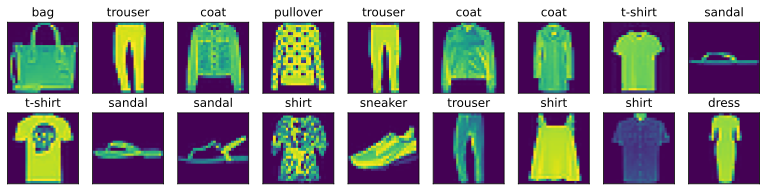

In [100]:
"""图片绘制测试"""
batch_size = 18
train_iter,test_iter = load_data_fashion_mnist(batch_size)
for X,y in train_iter:
    print(X.shape,X.dtype,y.shape,y.dtype)
    break
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## 3.2 softmax回归

### softmax回归从零开始
---
> - 数据
> - 模型
> - 损失函数
> - 分类精度
> - 预测

In [105]:
"""导入必要的库"""
import torch
from IPython import display
from d2l import torch as d2l

### 1.1 读取数据集
---
* 引入的Fashion-MNIST数据集
* 设置数据迭代器的批量大小为256。

In [107]:
"""读取数据集"""
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size) 

### 1.2 模型
---
> #### 1.2.1 初始化模型参数
>> * 展平每个图像，把它们看作长度为784的向量
>> * 使用正态分布初始化我们的权重W，偏置初始化为0。
> #### 1.2.2 定义`softmax`操作
>> - 对每个项求幂（使用exp）
>> - 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数
>> - 将每一行除以其规范化常数，确保结果的和为1。
> #### 1.2.3 定义模型
>> * 使用reshape函数将每张原始图像展平为向量

In [112]:
"""初始化模型参数"""
num_inputs = 784
num_outputs = 10
W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad = True)
b = torch.zeros(num_outputs,requires_grad = True)
"""定义softmax操作"""
def softMax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis = 1 ,keepdim = True) #partition 分母或规范化常数，有时也称为配分函数
    return X_exp/partition
"""定义模型"""
def net(X):
    return softMax(torch.matmul(X.reshape((-1,W.shape[0])), W) + b)

### 1.4 定义损失函数
* 交叉熵损失函数
* 交叉熵采用真实标签的预测概率的负对数似然。
---

In [113]:
"""交叉熵损失"""
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

### 1.5 分类精度
* 分类精度即正确预测数量与总预测数量之比
---

In [114]:
"""计算预测正确的数量"""
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] >1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
# accuracy(y_hat,y) / len(y)

In [115]:
"""计算在指定数据集上模型的精度"""
def evaluate_accuracy(net, data_iter):  
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [116]:
"""定义一个实用程序类Accumulator，用于对多个变量进行累加"""
class Accumulator: 
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

### 1.6 定义优化算法
 * 小批量随机梯度下降。
---

In [120]:
"""小批量随机梯度下降，设置学习率为0.1。"""
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

### 1.7 训练
>  1. 定义一个`train_epoch_ch3`函数来训练一个迭代周期
>  2. 定义一个在动画中绘制数据的实用程序类Animator
>  3. 实现一个训练函数`train_ch3`， 它会在train_iter访问到的训练数据集上训练一个模型net。 

In [117]:
"""训练模型一个迭代周期"""
def train_epoch_ch3(net,data_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()# 将模型设置为评估模式
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X,y in data_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater, torch.optim.Optimizer):
             # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
         # 返回训练损失和训练精度
    return metric[0]/metric[2],metric[1]/metric[2]

In [118]:
"""在动画中绘制数据"""
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self,x,y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [142]:
import time
import pandas as pd
"""训练模型（定义见第3章）"""
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    since = time.time()
    train_loss_all = []
    train_acc_all =[]
    test_acc_all =[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
        # ======================小循环结束========================
        train_loss_all.append(train_metrics[0])
        train_acc_all.append(train_metrics[-1])
        test_acc_all.append(test_acc)
        
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch+1, train_metrics[0], train_metrics[-1]))
        print('{} Test Acc: {:.4f}'.format(epoch+1, test_acc))
        
        time_use = time.time() - since
    print('Train and Test complete in {:.0f}m {:.0f}s'.format(time_use // 60, time_use % 60))
    train_loss,train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    # ===========================大循环结束===========================

    train_process = pd.DataFrame(
        data = {'epoch': range(num_epochs),
                'train_loss_all': train_loss_all,
                'train_acc_all': train_acc_all,
                'test_acc_all': test_acc_all})
    return train_process

10 Train Loss: 0.4479 Train Acc: 0.8472
10 Test Acc: 0.8304
Train and Test complete in 0m 31s


,epoch,train_loss_all,train_acc_all,test_acc_all
0,0,0.787093,0.747267,0.7908
1,1,0.569898,0.813683,0.8131
2,2,0.525094,0.825283,0.8173
3,3,0.501007,0.833050,0.8222
4,4,0.485650,0.836650,0.8177
5,5,0.474083,0.840517,0.8260
6,6,0.465363,0.843067,0.8255
7,7,0.457908,0.845850,0.8142
8,8,0.452669,0.846350,0.8294
9,9,0.447861,0.847217,0.8304


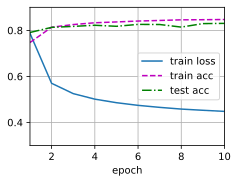

In [121]:
"""训练开始""" #训练模型10个迭代周期。 请注意，迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

- 可视化训练过程
---
```
train_process= train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)
import matplotlib.pyplot as plt

plt.figure(figsize = (3.5, 2.5))
plt.plot(train_process.epoch, train_process.train_loss_all, 'ro-', label = 'Train loss')
plt.plot(train_process.epoch, train_process.train_acc_all, 'bo-', label = 'Train acc')
plt.plot(train_process.epoch, train_process.test_acc_all, 'ks-', label = 'test acc')
plt.legend(['train loss', 'train acc', 'test acc'])
plt.xlabel('epoch')
plt.show()
```
---

### 1.8 预测
- 给定一系列图像，比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。
---

测试集上的预测精度为:84.38%


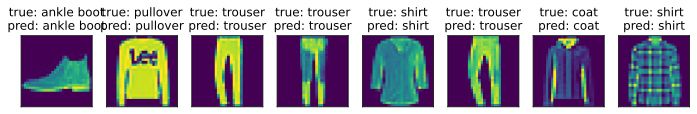

In [125]:
 """预测标签"""
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
def predict_ch3(net,test_iter,n = 8):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    y_hat = net(X).argmax(axis=1)
    preds = get_fashion_mnist_labels(y_hat)
    acc = accuracy_score(y_hat,y)
    # print('真实数据',y[:n])
    # print('预测数据',y_hat[:n])
    print(f'测试集上的预测精度为:{acc*100:.2f}%')
    titles = ['true: '+true + '\n' + 'pred: ' + pred for true,pred in zip(trues,preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net,test_iter)

* 计算测试集上的混淆矩阵并可视化
---
```
for X, y in test_iter:
    break
y_hat = net(X).argmax(axis=1)
labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
conf_mat = confusion_matrix(y, y_hat)
df_cm = pd.DataFrame(conf_mat, index = labels, columns = labels)
heatmap = sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
```
---

### softmax回归简洁实现
---
> - 数据
> - 模型
> - 损失函数
> - 分类精度
> - 预测

In [ ]:
"""导入必要的库"""
import torch
from IPython import display
from d2l import torch as d2l

### 1.1 读取数据集
---
* 引入的Fashion-MNIST数据集
* 设置数据迭代器的批量大小为256。

In [143]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 1.2 模型
---
> #### 1.2.1 初始化模型参数
>> * 展平每个图像，把它们看作长度为784的向量
>> * 使用正态分布初始化我们的权重W，偏置初始化为0。
> #### 1.2.2 重新定义`softmax`操作
>> - 交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数
>> - 一种类似“LogSumExp技巧”的聪明方式
> #### 1.2.3 定义模型
>> * 在Sequential中添加一个带有10个输出的全连接层

In [144]:
from torch import nn
"""定义神经网络模型"""
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
"""初始化模型参数"""
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
"""定义softmax操作"""
loss = nn.CrossEntropyLoss(reduction='none')

### 1.3 定义优化算法
---
 * 小批量随机梯度下降
 * 学习率lr = 0.1

In [145]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 1.7 训练
---

10 Train Loss: 0.4474 Train Acc: 0.8482
10 Test Acc: 0.8208
Train and Test complete in 0m 31s


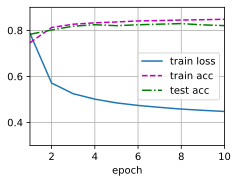

In [146]:
"""训练开始"""
num_epochs = 10
train_process = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

测试集上的预测精度为:83.98%


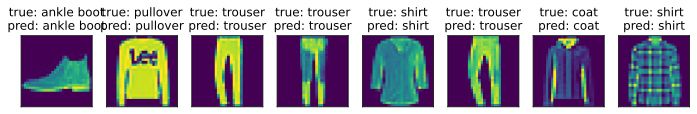

In [147]:
predict_ch3(net,test_iter)

### 0 激活函数
---
 * ReLU函数
 * sigmoid函数
 * tanh函数

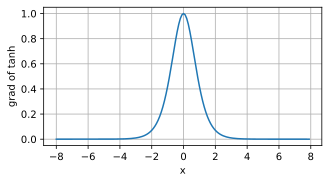

In [148]:
# ReLU函数
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(),y.detach(),'x','relu(x)',figsize=(5,2.5))

y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of relu',figsize=(5,2.5))

# sigmoid 函数
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(),'x','sigmoid(x)',figsize=(5,2.5))

# 清除以前的梯度
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of sigmoid',figsize=(5,2.5))

# tanh 函数
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(),'x','tanh(x)',figsize=(5,2.5))

# 清除以前的梯度
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of tanh',figsize=(5,2.5))

### 全连接神经网络MLP(多层感知机)
---
> - 从零开始实现
> - 简洁实现
> - 网络结构

In [ ]:
"""从零开始实现"""
#导入必要的库
import torch
from torch import nn
from d2l import torch as d2l
#加载数据集
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
#单隐藏层，初始化模型参数
num_inputs,num_outputs,num_hiddens= 784,10,256
W1 = nn.Parameter(torch.randn(
    num_inputs,num_hiddens,requires_grad = True)*0.01) #torch.randn是生成以0为均值1为方差的随机数，要求0.01
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad = True))
W2 = nn.Parameter(torch.randn(
    num_hiddens,num_outputs,requires_grad = True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad = True))

params = [W1,b1,W2,b2]
#定义神经网络模型
def net(X):
    X = X.reshape(-1,num_inputs)
    H = relu(X@W1 + b1) # 这里“@”代表矩阵乘法
    return relu(H@W2 +b2)
#激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)
#损失函数
loss = nn.CrossEntropyLoss(reduction='none')
num_epochs, lr = 10, 0.1
#优化算法
trainer = torch.optim.SGD(params, lr=lr) 
"""训练"""
train_process = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
"""预测"""
predict_ch3(net,test_iter)

In [ ]:
"""简洁实现"""
#导入必要的库
import torch
from torch import nn
from d2l import torch as d2l
#加载数据集
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
#定义神经网络模型
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))
#初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

#损失函数
loss = nn.CrossEntropyLoss(reduction='none')
lr, num_epochs = 0.1, 10
#优化算法
trainer = torch.optim.SGD(net.parameters(), lr=lr)
"""训练"""
train_process = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
"""预测"""
predict_ch3(net,test_iter)

# MLP网络结构可视化
---
```
#搭建方法1
class myMLP1(nn.Module):
    def __init__(self):
        super().__init__()
        nn.Flatten()
        self.hidden = nn.Linear(784,256)
        self.active = nn.ReLU()
        self.output = nn.Linear(256,10)
    def forward(self,x):
        return self.output(self.active(self.hidden(x)))
#搭建方法2
class myMLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
                    nn.Flatten(), 
                    nn.Linear(784, 256),
                    nn.ReLU())
        self.output = nn.Linear(256,10)
    def forward(self,x):
        return self.output(self.hidden(x))
```
## 输出网络结构
---
```
 !pip install torchsummary
myNet = myMLP2()
from torchsummary import summary
summary(myNet, input_size=(1,784))
```
## 可视化网络结构
---
```
!pip install torchviz
from torchviz import make_dot

x = torch.randn(1, 784).requires_grad_(True)
y = myNet(x)
myCNN_vis = make_dot(y, params=dict(list(myNet.named_parameters()) + [('x', x)]))
myCNN_vis
```

### 4.抑制过拟合
---
> - 权重衰减
> - 暂退法(dropout)

In [149]:
# 导入必要的库
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [150]:
#生成数据
n_train, n_test, num_inputs, batch_size = 20, 20, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size,is_train=False)

In [151]:
#随机初始化模型参数
def init_params():
    w = torch.normal(0,0.01,size=(num_inputs,1),requires_grad = True)
    b = torch.zeros(1,requires_grad = True)
    return [w,b]
#定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2))/2
#定义L21范数惩罚
def l1_penalty(w):
    return torch.sum(abs(w))

In [152]:
#定义训练代码
def train(lambd,penalty = l2_penalty):
    w,b = init_params()
    net,loss = lambda X: d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel = 'loss', yscale = 'log',
                        xlim=[5, num_epochs],
                        legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X),y)  +  lambd * penalty(w)
            l.sum().backward() 
            d2l.sgd([w,b],lr,batch_size)
        if (epoch +1 ) % 5 == 0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                                 d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是:',torch.norm(w).item())

w的L2范数是: 0.13663871586322784


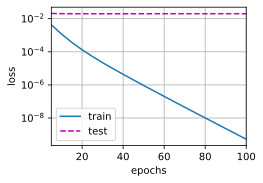

In [153]:
#忽略正则化直接训练
train(lambd = 0)

w的L2范数是: 0.029088925570249557


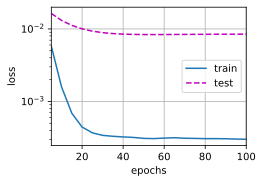

In [154]:
#使用权重衰减
train(lambd = 3)

In [155]:
#简洁实现
#将权重衰减集成到优化算法
#定义训练代码
##指定weight decay超参数
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction = 'none') #返回tensor 格式
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([{'params':net[0].weight,'weight_decay':wd},
                               {'params':net[0].bias}], lr=lr)
    animator = Animator(xlabel='epochs', ylabel = 'loss', yscale = 'log',
                        xlim=[5, num_epochs],
                        legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward() 
            trainer.step()
        if (epoch +1 ) % 5 == 0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net,train_iter,loss),
                         d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是:',net[0].weight.norm().item())

w的L2范数是: 14.717682838439941


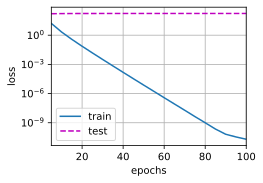

In [156]:
#忽略正则化直接训练
train_concise(wd = 0)

w的L2范数是: 0.41402187943458557


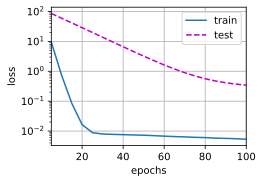

In [157]:
#使用权重衰减
train_concise(wd = 3)

### 暂退法Dropout
---
> - 暂退法在前向传播过程中，计算每一内部层的同时丢弃一些神经元。
> - 暂退法可以避免过拟合，它通常与控制权重向量的维数和大小结合使用的。
> - 暂退法将活性值替换为具有期望值的随机变量。
> - 暂退法仅在训练期间使用

In [158]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float() # 随机数> dropout,置为true -> 1.0，否则 置为false -> 0.0
    return mask * X / (1.0 - dropout)

In [159]:
###定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1,dropout2 = 0.2,0.5
###定义模型
#将暂退法应用于每个隐藏层的输出（在激活函数之后）， 并且可以为每一层分别设置暂退概率：
 #常见的技巧是在靠近输入层的地方设置较低的暂退概率。
# 并且暂退法只在训练期间有效。
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs,num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1,num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2,num_outputs)
        self.relu = nn.ReLU()
    def forward(self,X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs)))) # torch.Size([256, 1, 28, 28]) -> torch.Size([256, 784])
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1,dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2,dropout2)
        out = self.lin3(H2)
        return out
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2) 

10 Train Loss: 0.3874 Train Acc: 0.8627
10 Test Acc: 0.8550
Train and Test complete in 0m 35s


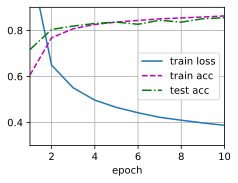

In [160]:
num_epochs,lr, batch_size= 10,0.1,256
#损失函数
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
#优化算法
trainer = torch.optim.SGD(net.parameters(), lr=lr)
"""训练"""
train_process = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

10 Train Loss: 0.4209 Train Acc: 0.8507
10 Test Acc: 0.8481
Train and Test complete in 0m 35s


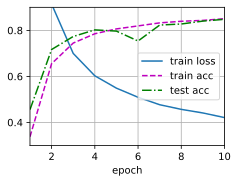

In [161]:
###简洁实现
#导入必要的库
import torch
from torch import nn
from d2l import torch as d2l
#加载数据集
batch_size = 256
dropout1,dropout2 = 0.2,0.5
train_iter, test_iter = load_data_fashion_mnist(batch_size)
#定义神经网络模型
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # 在第一个全连接层之后添加一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                     # 在第二个全连接层之后添加一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))
#初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

#损失函数
loss = nn.CrossEntropyLoss(reduction='none')
lr, num_epochs = 0.1, 10
#优化算法
trainer = torch.optim.SGD(net.parameters(), lr=lr)
"""训练"""
train_process = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 5. kaggle实战
---
> - 数据预处理
> - 模型训练
> - K折交叉验证
> - 提交预测

#### 5.1 数据预处理
---
- 数值型,标准化、nan缺省值处理
- 离散型数据，独热编码